In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_excel('dgcase.xlsx', sheet_name = None)
xlsx = pd.ExcelFile('dgcase.xlsx')
xlsx.sheet_names #資料頁箋

['total', 'AST', 'ALT', 'APTT', 'Platelet']

# 資料前處理

醫療上的指數取第一天或最小天數時，並將散落在各sheet的病歷資料整合在一起

並將發病日和確診日整合成diag-onset值

In [2]:
sheet1=data.get('total').sort_values('chartno', ascending=True)
sheet1.set_index("chartno", inplace=True)

sheet2_finish=data.get('AST').sort_values('Day', ascending=True).drop_duplicates('chartno')
sheet2_finish=sheet2_finish.sort_values('chartno', ascending=True)
sheet2_finish.set_index("chartno", inplace=True)
sheet2_finish=sheet2_finish.rename(columns={"value":"AST_value"})

sheet3_finish=data.get('ALT').sort_values('Day', ascending=True).drop_duplicates('chartno')
sheet3_finish=sheet3_finish.sort_values('chartno', ascending=True)
sheet3_finish.set_index("chartno", inplace=True)
sheet3_finish=sheet3_finish.rename(columns={"value":"ALT_value"})

sheet4_finish=data.get('APTT').sort_values('Day', ascending=True).drop_duplicates('chartno')
sheet4_finish=sheet4_finish.sort_values('chartno', ascending=True)
sheet4_finish.set_index("chartno", inplace=True)
sheet4_finish=sheet4_finish.rename(columns={"value":"APTT_value"})

sheet5_finish=data.get('Platelet').sort_values('Day', ascending=True).drop_duplicates('chartno')
sheet5_finish=sheet5_finish.sort_values('chartno', ascending=True)
sheet5_finish.set_index("chartno", inplace=True)
sheet5_finish=sheet5_finish.rename(columns={"value":"Platelet_value"})

import time
import datetime

sheet2_finish=sheet2_finish.drop(['type', 'Day'],axis=1)
sheet3_finish=sheet3_finish.drop(['type', 'Day'],axis=1)
sheet4_finish=sheet4_finish.drop(['type', 'Day'],axis=1)
sheet5_finish=sheet5_finish.drop(['type', 'Day'],axis=1)

sheet=pd.concat([sheet1, sheet2_finish, sheet3_finish, sheet4_finish, sheet5_finish],axis=1)
for i in sheet.index[:]:
    result=datetime.datetime.strptime(sheet.loc[i, 'diag_date'], '%Y-%m-%d')-datetime.datetime.strptime(sheet.loc[i, 'onset_date'], '%Y-%m-%d')
    sheet.loc[i, 'diag-onset']=result.days

#丟棄無用
finaldata=sheet.drop(['onset_date', 'diag_date', 'death_date'],axis=1)
finaldata.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,age,sex,is_hospitalization,Fatal,AST_value,ALT_value,APTT_value,Platelet_value,diag-onset
A10015442,36,1,0,0,39.0,25.0,36.6,NaN,2.0
A10017629,35,1,0,0,58.0,42.0,33.2,NaN,3.0
A10030438,75,0,1,0,45.0,10.0,40.5,51.0,0.0
A10031096,65,1,0,0,81.0,41.0,NaN,120.0,0.0
A10034524,58,0,0,0,27.0,13.0,NaN,93.0,2.0


### 空缺值不少，且樣本落差大，故原本用平均數中位數填值，改成用random forest，觀察其他數據表現來填值

In [3]:
from  sklearn.ensemble import RandomForestRegressor

def fillvalue(data,attrname):
#以資料完整的筆數建立預測空缺值模型
    tr=data[data[attrname].notnull()]
    tr_X=tr[['age','sex','is_hospitalization','diag-onset']] 
    tr_Y=tr[[attrname]] 
    tr_X=tr_X.astype(float)
    tr_Y=tr_Y.astype(float)

    te=data[data[attrname].isnull()]
    te_X=te[['age','sex','is_hospitalization','diag-onset']].astype(float) #設定輸入的X
    te_Y=te[attrname].astype(float) #欲填補的空值y
    
    fc=RandomForestRegressor()
    fc.fit(tr_X,tr_Y)
    pr=fc.predict(te_X)
    for i in range(len(pr)):
        te[attrname].values[i]=pr[i]
    return(te)

te_AST=fillvalue(finaldata,'AST_value')
final=pd.concat([finaldata, te_AST],axis=0)
final.reset_index(inplace=True)
final.drop_duplicates('index',keep='last',inplace=True)
final = final.rename(columns={'index': 'chartno'})
final_AST=final.reset_index(drop=True)

te_ALT=fillvalue(final_AST,'ALT_value')
final_ALT=pd.concat([final_AST, te_ALT],axis=0)
final_ALT.drop_duplicates('chartno',keep='last',inplace=True)
final_ALT=final_ALT.reset_index(drop=True)

te_APTT=fillvalue(final_ALT,'APTT_value')
final_APTT=pd.concat([final_ALT, te_APTT],axis=0)
final_APTT.drop_duplicates('chartno',keep='last',inplace=True)
final_APTT=final_APTT.reset_index(drop=True)

te_Platelet=fillvalue(final_APTT,'Platelet_value')
final_Platelet=pd.concat([final_APTT, te_Platelet],axis=0)
final_Platelet.drop_duplicates('chartno',keep='last',inplace=True)
final_Platelet=final_Platelet.reset_index(drop=True)

finaldata=final_Platelet.sort_values('chartno', ascending=True)
finaldata.set_index("chartno", inplace=True)
finaldata.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-

,age,sex,is_hospitalization,Fatal,AST_value,ALT_value,APTT_value,Platelet_value,diag-onset
chartno,,,,,,,,,
A10015442,36,1,0,0,39.0,25.0,36.600000,98.301667,2.0
A10017629,35,1,0,0,58.0,42.0,33.200000,83.650000,3.0
A10030438,75,0,1,0,45.0,10.0,40.500000,51.000000,0.0
A10031096,65,1,0,0,81.0,41.0,39.818000,120.000000,0.0
A10034524,58,0,0,0,27.0,13.0,35.936833,93.000000,2.0


# 資料視覺化

### 為甚麼Platelet_value的相關係數低? 
因為本來登革熱就會造成血小板偏低，所以普遍的血小板都偏低，除非是登革出血熱才會特別低

資料來源:衛生署https://www.cdc.gov.tw/File/Get/fSxR6Vffn86b75R74dTKNg P.17

Text(0.5, 1.0, 'Correlation')

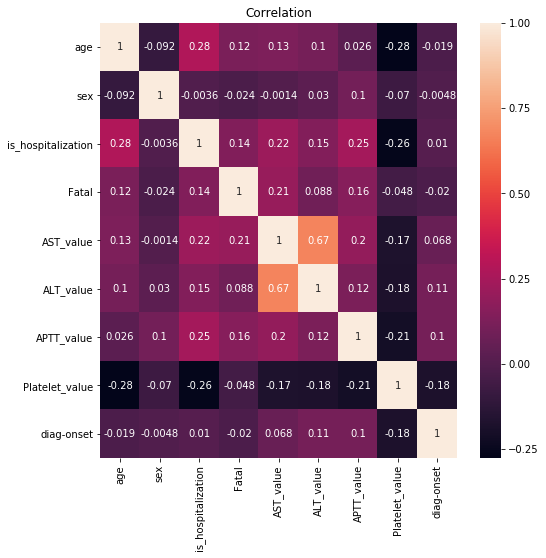

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(finaldata.corr(), annot=True).set_title('Correlation')

### 性別與存活死亡的關係
男女之間得病機率幾乎相同，但是女性死亡比例稍高

<function matplotlib.pyplot.show(*args, **kw)>

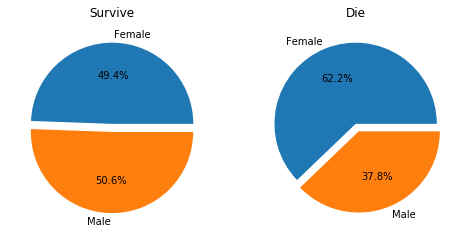

In [5]:
plt.figure(figsize=(8, 6))
labels = 'Female','Male'
FS=list(finaldata.loc[finaldata['Fatal']==0,'sex']).count(0)
FD=list(finaldata.loc[finaldata['Fatal']==1,'sex']).count(0)
MS=list(finaldata.loc[finaldata['Fatal']==0,'sex']).count(1)
MD=list(finaldata.loc[finaldata['Fatal']==1,'sex']).count(1)
size1 = [FS,MS]
size2 = [FD,MD]
plt.subplot(1,2,1)
plt.pie(size1, labels = labels, autopct='%1.1f%%',explode=(0,0.1))
plt.title("Survive")
plt.subplot(1,2,2)
plt.pie(size2, labels = labels, autopct='%1.1f%%',explode=(0,0.1))
plt.title("Die")
plt.show

### 住院與否和存活死亡的關係
未住院的患者中幾乎無人死亡，推測是因為醫師準確判斷病情並不嚴重，故未安排住院

相對的，住院的患者相對危險，死亡比例也就較高

<function matplotlib.pyplot.show(*args, **kw)>

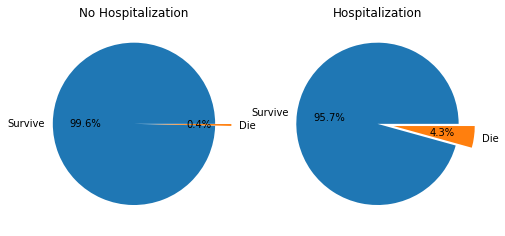

In [6]:
plt.figure(figsize=(8, 6))
labels1 = 'Survive','Die'
NHS=list(finaldata.loc[finaldata['Fatal']==0,'is_hospitalization']).count(0)
NHD=list(finaldata.loc[finaldata['Fatal']==1,'is_hospitalization']).count(0)
HS=list(finaldata.loc[finaldata['Fatal']==0,'is_hospitalization']).count(1)
HD=list(finaldata.loc[finaldata['Fatal']==1,'is_hospitalization']).count(1)
size1 = [NHS,NHD]
size2 = [HS,HD]
plt.subplot(1,2,1)
plt.pie(size1, labels = labels1, autopct='%1.1f%%',explode=(0,0.2))
plt.title("No Hospitalization")
plt.subplot(1,2,2)
plt.pie(size2, labels = labels1, autopct='%1.1f%%',explode=(0,0.2))
plt.title("Hospitalization")
plt.show

### 年齡與死亡和住院與否的關係
可以合理推測年齡越高，患病後的風險也就越高

故不論是死亡或住院的曲線都偏右，也就是年齡高的族群

Text(0, 0.5, 'Number of Hospitalization')

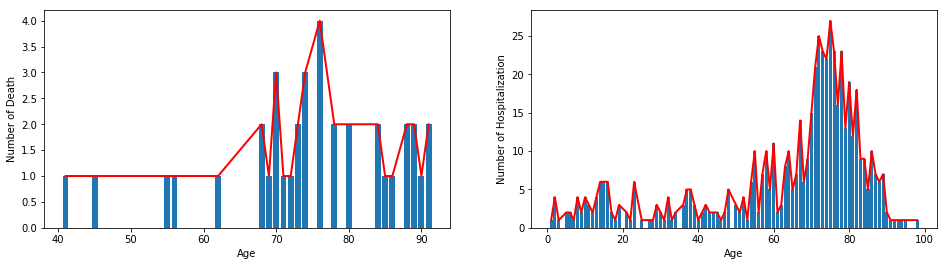

In [7]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.bar(finaldata["age"].groupby([finaldata.loc[finaldata['Fatal']==1,"age"]]).count().index, finaldata["age"].groupby([finaldata.loc[finaldata['Fatal']==1,"age"]]).count())
plt.plot(finaldata["age"].groupby([finaldata.loc[finaldata['Fatal']==1,"age"]]).count().index, finaldata["age"].groupby([finaldata.loc[finaldata['Fatal']==1,"age"]]).count(),c='red',ls='-',lw=2)
plt.xlabel("Age") 
plt.ylabel("Number of Death") 

plt.subplot(1,2,2)
plt.bar(finaldata["age"].groupby([finaldata.loc[finaldata['is_hospitalization']==1,"age"]]).count().index, finaldata["age"].groupby([finaldata.loc[finaldata['is_hospitalization']==1,"age"]]).count())
plt.plot(finaldata["age"].groupby([finaldata.loc[finaldata['is_hospitalization']==1,"age"]]).count().index, finaldata["age"].groupby([finaldata.loc[finaldata['is_hospitalization']==1,"age"]]).count(),c='red',ls='-',lw=2)
plt.xlabel("Age") 
plt.ylabel("Number of Hospitalization") 

### 登革熱好發時期
由圖可以看出登革熱流行的巔峰在7至10月之間，與一般人印象相符

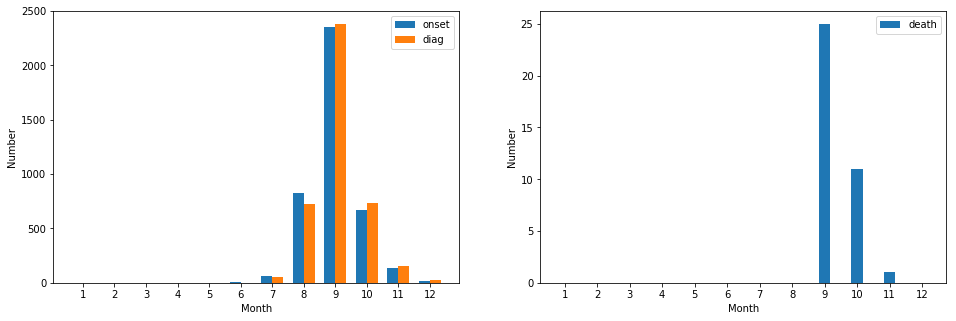

In [8]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
onset_month=np.zeros(12)
diag_month=np.zeros(12)
death_month=np.zeros(12)
for i in sheet1.index[:]:
    onset_month[datetime.datetime.strptime(sheet1.loc[i, 'onset_date'], '%Y-%m-%d').month-1]=onset_month[datetime.datetime.strptime(sheet1.loc[i, 'onset_date'], '%Y-%m-%d').month-1]+1
    diag_month[datetime.datetime.strptime(sheet1.loc[i, 'diag_date'], '%Y-%m-%d').month-1]=diag_month[datetime.datetime.strptime(sheet1.loc[i, 'diag_date'], '%Y-%m-%d').month-1]+1
    if sheet1.loc[i,'Fatal']==1:
        death_month[datetime.datetime.strptime(sheet1.loc[i, 'death_date'], '%Y-%m-%d').month-1]=death_month[datetime.datetime.strptime(sheet1.loc[i, 'death_date'], '%Y-%m-%d').month-1]+1
plt.bar(np.arange(1,13),onset_month,0.35,label='onset')
plt.bar(np.arange(1,13)+0.35,diag_month,0.35,label='diag')
plt.xticks(np.arange(1,13)+0.175,np.arange(1,13))
plt.legend()
plt.xlabel("Month") 
plt.ylabel("Number") 

plt.subplot(1,2,2)
plt.bar(np.arange(1,13),death_month,0.35,label='death')
plt.xticks(np.arange(1,13),np.arange(1,13))
plt.xlabel("Month") 
plt.ylabel("Number") 
plt.legend()

### 4個指數和存活死亡的關係
由左圖大致可以看出AST與死亡率相關性較高，右圖則顯示APTT的高相關性

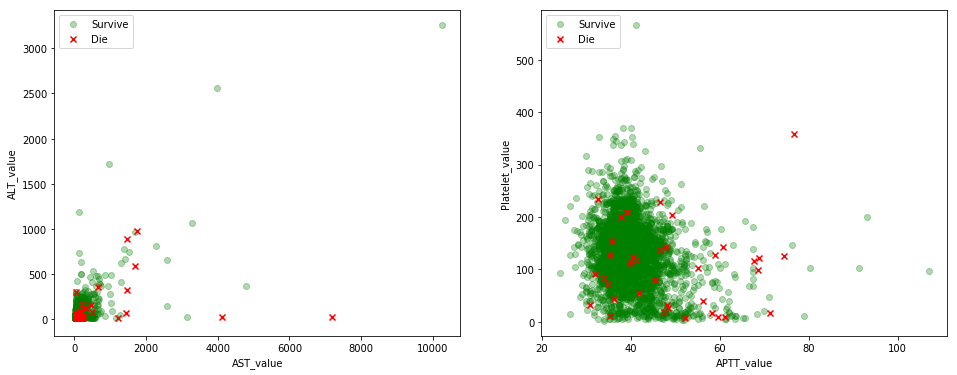

In [9]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
X1=finaldata.loc[finaldata['Fatal']==0,'AST_value']
Y1=finaldata.loc[finaldata['Fatal']==0,'ALT_value']
c1="green"
X2=finaldata.loc[finaldata['Fatal']!=0,'AST_value']
Y2=finaldata.loc[finaldata['Fatal']!=0,'ALT_value']
c2="red"
plt.scatter(X1, Y1, marker='o', c=c1, alpha=.3, label="Survive")
plt.scatter(X2, Y2, marker='x', c=c2, alpha=1, label="Die")
plt.xlabel('AST_value')
plt.ylabel('ALT_value')
plt.legend(loc="upper left")

plt.subplot(1,2,2)
X1=finaldata.loc[finaldata['Fatal']==0,'APTT_value']
Y1=finaldata.loc[finaldata['Fatal']==0,'Platelet_value']
c1="green"
X2=finaldata.loc[finaldata['Fatal']!=0,'APTT_value']
Y2=finaldata.loc[finaldata['Fatal']!=0,'Platelet_value']
c2="red"
plt.scatter(X1, Y1, marker='o', c=c1, alpha=.3, label="Survive")
plt.scatter(X2, Y2, marker='x', c=c2, alpha=1, label="Die")
plt.xlabel('APTT_value')
plt.ylabel('Platelet_value')
plt.legend(loc="upper left")

plt.show()

# 訓練模型：決策樹

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(finaldata.loc[:, finaldata.columns!='Fatal'], finaldata.loc[:, 'Fatal'], test_size=0.3, random_state=1)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO   
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import accuracy_score

dtree=DecisionTreeClassifier(max_depth=4)
dtree.fit(X_train,y_train)

dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                feature_names=list(X_train),
                class_names=['die','survive'],
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("tree.png")

y_predict = dtree.predict(X_test)
print("\n準確度 : ", accuracy_score(y_test, y_predict))
pd.DataFrame([dtree.feature_importances_],index=None, columns = X_train.columns)


準確度 :  0.9901719901719902


,age,sex,is_hospitalization,AST_value,ALT_value,APTT_value,Platelet_value,diag-onset
0,0.083073,0.0,0.0,0.301001,0.115892,0.291595,0.208439,0.0


### 捨棄與Fatal相關性低的特徵

In [12]:
finaldata1=finaldata.drop(['sex', 'Platelet_value', 'diag-onset'],axis=1)
X_train1=X_train.drop(['sex', 'Platelet_value', 'diag-onset'],axis=1)
X_test1=X_test.drop(['sex', 'Platelet_value', 'diag-onset'],axis=1)

In [13]:
dtree=DecisionTreeClassifier(max_depth=4)
dtree.fit(X_train1,y_train)

dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                feature_names=list(X_train1),
                class_names=['survive','die'],
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("tree1.png")

y_predict = dtree.predict(X_test1)
print("\n準確度 : ", accuracy_score(y_test, y_predict))
pd.DataFrame([dtree.feature_importances_],index=None, columns = X_train1.columns)


準確度 :  0.9893529893529893


,age,is_hospitalization,AST_value,ALT_value,APTT_value
0,0.162956,0.0,0.307216,0.120239,0.409589


###  決策樹模型分析

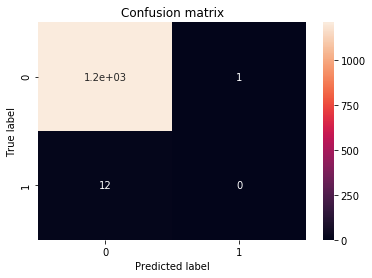

,Precision,Recall,FPR,TPR,F1
0,99.917287,99.016393,100.0,99.016393,99.4648


In [14]:
from sklearn.metrics import confusion_matrix,auc,roc_curve
C=confusion_matrix(y_test, y_predict)
ax = plt.axes()
sns.heatmap(C, annot=True,ax=ax)
ax.set_title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

FPR=C[0][1]/(C[0][1]+C[1][1])*100
TPR=C[0][0]/(C[0][0]+C[1][0])*100
P=C[0][0]/(C[0][0]+C[0][1])*100
R=C[0][0]/(C[0][0]+C[1][0])*100
F1=2*P*R/(P+R)

scores=[[P,R,FPR,TPR,F1]]
subject = ['Precision', 'Recall', 'FPR', 'TPR', 'F1']
df = pd.DataFrame(scores,index=None, columns = subject)
df

<Figure size 432x288 with 0 Axes>

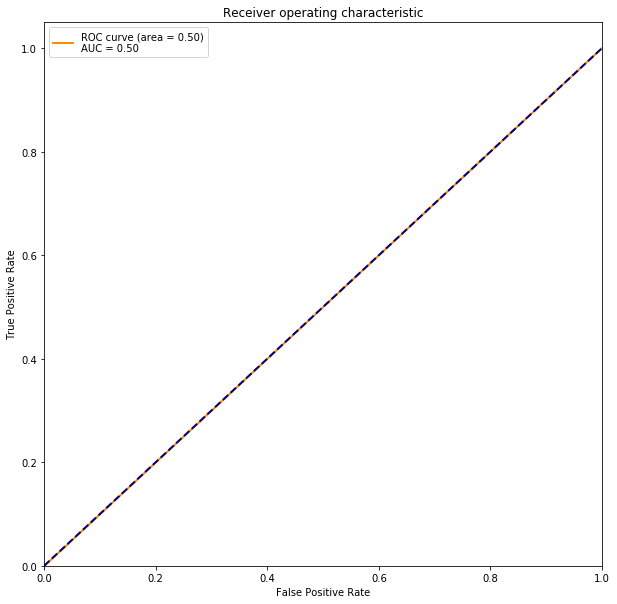

In [15]:
y_score = dtree.fit(X_train1, y_train).predict(X_test1)

fpr,tpr,threshold = roc_curve(y_test, y_score) #計算FPR和TPR
roc_auc = auc(fpr,tpr) #計算auc的值
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)\nAUC = %0.2f' % (roc_auc,roc_auc)) #FPR為X軸，TPR為Y軸
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper left")
plt.show()

# SVM模型及其分析

In [16]:
from sklearn import svm,preprocessing

classifier = svm.SVC(1, kernel='rbf',gamma='auto') 
classifier.fit(X_train1,y_train)
y_predict2=classifier.predict(X_test1)
print("準確度 : ", accuracy_score(y_test, y_predict2))

準確度 :  0.9901719901719902


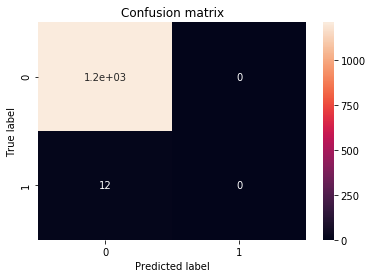

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':


,Precision,Recall,FPR,TPR,F1
0,100.0,99.017199,NaN,99.017199,99.506173


In [17]:
C=confusion_matrix(y_test, y_predict2)
ax = plt.axes()
sns.heatmap(C, annot=True,ax=ax)
ax.set_title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

FPR=C[0][1]/(C[0][1]+C[1][1])*100
TPR=C[0][0]/(C[0][0]+C[1][0])*100
P=C[0][0]/(C[0][0]+C[0][1])*100
R=C[0][0]/(C[0][0]+C[1][0])*100
F1=2*P*R/(P+R)

scores=[[P,R,FPR,TPR,F1]]
subject = ['Precision', 'Recall', 'FPR', 'TPR', 'F1']
df = pd.DataFrame(scores,index=None, columns = subject)
df

### ROC及AUC

<Figure size 432x288 with 0 Axes>

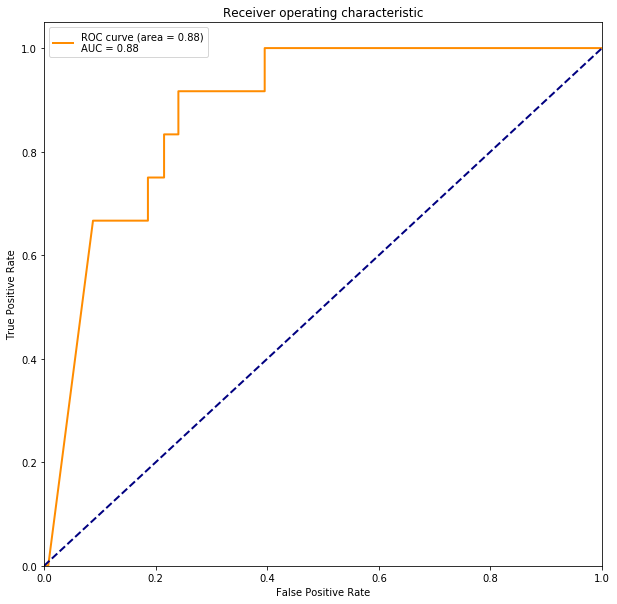

In [18]:
y_score = classifier.fit(X_train1, y_train).decision_function(X_test1)

fpr,tpr,threshold = roc_curve(y_test, y_score) #計算FPR和TPR
roc_auc = auc(fpr,tpr) #計算auc的值
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)\nAUC = %0.2f' % (roc_auc,roc_auc)) #FPR為X軸，TPR為Y軸
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper left")
plt.show()